The notebook details how to implement a machine learning model able to determine if an article is fake news or not. 

Covers exploratory data analysis, modeling, training, and evaluating model performance

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, RandomSampler
from transformers import BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import trange
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

## Analyze the Dataset

In [2]:
fake_df = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
true_df = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")

Look at some of the fake articles

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Look at some of the real articles

In [4]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Set the corresponding output classes for the fake and real articles and merge all the articles into a single dataframe

In [5]:
fake_df["output"] = 0
true_df["output"] = 1

In [6]:
df = fake_df.append(true_df).sample(frac=1).reset_index(drop=True) #shuffle data after append

# check the number of rows and columns in the training set
print("Number of data examples: {} \n".format(df.shape[0]))
print("Number of data columns: {} \n".format(df.shape[1]))

df.head()

Number of data examples: 44898 

Number of data columns: 5 



,title,text,subject,date,output
0,BREAKING…OBAMA’S WAR ON COPS: ANOTHER Cop Ambu...,"Did America really expect this racist, Communi...",left-news,"Jul 8, 2016",0
1,WIKILEAKS REMINDS THE WORLD: “Obama has a hist...,Wikileaks founder Julian Assange reminded us i...,left-news,"Mar 5, 2017",0
2,Australian PM says he's confident Trump won't ...,SYDNEY (Reuters) - Australian Prime Minister M...,politicsNews,"December 4, 2016",1
3,Battle lines drawn for South Africa's ANC on e...,JOHANNESBURG (Reuters) - The African National ...,worldnews,"December 15, 2017",1
4,WATCH: Black Panelists SHUT DOWN Trump Fan Fo...,Donald Trump s efforts to reach out to voters ...,News,"August 20, 2016",0


Find any missing values and drop the corresponding rows

In [7]:
# print out stats about data 

# replace empty strings with nan type
# df["title"].replace(" ", np.nan, inplace=True)
# df["text"].replace(" ", np.nan, inplace=True)

missing_values_count = df.isnull().sum() # we get the number of missing data points per column
print("Number of missing data points per column:\n")
print (missing_values_count)

df.dropna(inplace=True) #drop the empty rows

Number of missing data points per column:

title      0
text       0
subject    0
date       0
output     0
dtype: int64


Let's look at the distribution of subject in the dataset.

In [8]:
df.subject.value_counts(normalize=True)

politicsNews       0.251058
worldnews          0.225957
News               0.201568
politics           0.152368
left-news          0.099314
Government News    0.034968
US_News            0.017440
Middle-east        0.017328
Name: subject, dtype: float64

Most of the articles are on politics and world news.

Let's now look at the subject distribution per output class.

In [9]:
# Calculate subject counts per output class
info_per_class = df.groupby(["output", "subject"]).size()
print (info_per_class)

output  subject        
0       Government News     1570
        Middle-east          778
        News                9050
        US_News              783
        left-news           4459
        politics            6841
1       politicsNews       11272
        worldnews          10145
dtype: int64


From above, we can see that while true articles in this dataset only cover politics and world news, fake articles cover different subjects.

Let's now visualize the distribution of class labels over the entire dataset

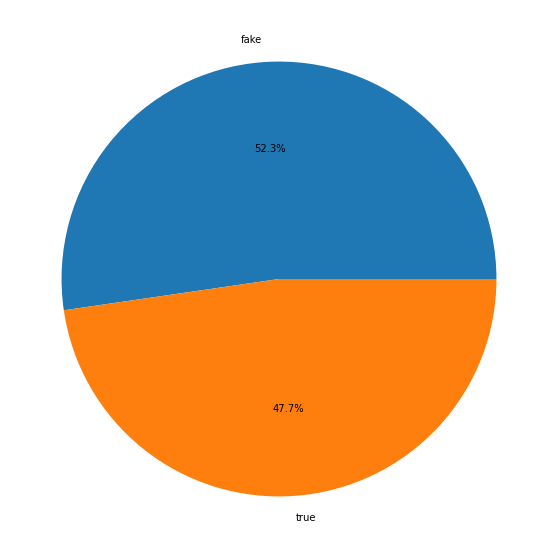

In [10]:
# counts for all classes
counts = df["output"].value_counts()

class_labels = ["fake", "true"]

counts_per_class = [counts[0], counts[1]]

# counts.plot(kind='barh')

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.show()

From the chart above, we can see that the dataset is decently balanced over the 2 classes.

Let's now look at the word length distribution for the title and text columns

In [11]:
df["title_length"] = df["title"].apply(lambda x: len(x.split()))
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
df.describe()

,output,title_length,text_length
count,44898.000000,44898.000000,44898.000000
mean,0.477015,12.453472,405.282284
std,0.499477,4.111476,351.265595
min,0.000000,1.000000,0.000000
25%,0.000000,10.000000,203.000000
50%,0.000000,11.000000,362.000000
75%,1.000000,14.000000,513.000000
max,1.000000,42.000000,8135.000000


Visualize the histogram title length distribution

Text(0, 0.5, 'Count')

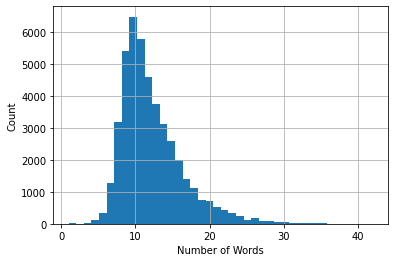

In [12]:
df["title_length"].hist(bins=40)
plt.xlabel("Number of Words")
plt.ylabel("Count")

Identify any duplicate examples in the dataset

In [13]:
df["is_duplicate"] = df.duplicated()
df[df["is_duplicate"]==True].count() 

title           209
text            209
subject         209
date            209
output          209
title_length    209
text_length     209
is_duplicate    209
dtype: int64

Drop the duplicated examples from the dataset before splitting the data into train-validation-test subsets. This prevents any accidental test or validation data leakage into the train subset.

In [14]:
df.drop_duplicates(keep=False, inplace=True, ignore_index=True)
df.drop("is_duplicate", axis=1, inplace=True) 
print("Number of data examples after dropping duplicates: {} \n".format(df.shape[0]))

Number of data examples after dropping duplicates: 44881 



## Train-Validation-Test Split

In [15]:
train_df, sub_df = train_test_split(df, stratify=df.output.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

validation_df, test_df = train_test_split(sub_df, stratify=sub_df.output.values, 
                                                  random_state=42, 
                                                  test_size=0.25, shuffle=True)


train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [16]:
# We check the number of examples after split
print("Train data: {} \n".format(train_df.shape))
print("Validation data: {} \n".format(validation_df.shape))
print("Test data: {} \n".format(test_df.shape))

Train data: (35904, 7) 

Validation data: (6732, 7) 

Test data: (2245, 7) 



## Process and Load the Data

Initialize the tokenizer

In [17]:
# model_name = "bert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

model_name = "distilbert-base-uncased" #faster
tokenizer = DistilBertTokenizer.from_pretrained(model_name, do_lower_case=True)

tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

The title strings of the articles will be fed as input to the model. Since the title sequences are of varying lengths, the input sequences are padded to a fixed length. From the above histogram for title length distribution, it can seen that most of titles are no more than 30 words long. Hence the MAX_LEN is set to 30 to ensure not too much information is lost

In [18]:
# Configuration Settings
NUM_LABELS = 2
BATCH_SIZE = 32
MAX_LEN = 30
EPOCHS = 3
LEARNING_RATE = 1e-5

Data preparation includes preprocessing steps such as lower casing the title strings, applying tokenization and vectorization to feed numerical data to the machine learning model. The examples are then fed as batches during the training phase.

In [19]:
def process_data(df, tokenizer, max_len=30):
    """
    Process the data to feed into the pretrained model
    """
    data_processed = tokenizer.batch_encode_plus(df.title.values, pad_to_max_length=True, truncation=True, add_special_tokens=True, return_attention_mask=True, max_length=max_len, return_tensors='pt')
    input_ids_train = data_processed["input_ids"]
    attention_mask_train = data_processed["attention_mask"]
    output_train = torch.tensor(df.output.values)
    return input_ids_train, attention_mask_train, output_train

input_ids_train, attention_mask_train, output_train = process_data(train_df, tokenizer, max_len=MAX_LEN)
input_ids_val, attention_mask_val, output_val = process_data(validation_df, tokenizer, max_len=MAX_LEN)
input_ids_test, attention_mask_test, output_test = process_data(test_df, tokenizer, max_len=MAX_LEN)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
def load_data(seq, mask, output, batch_size=32, use_train=True):
    """
    Load data into batches
    """
    data = TensorDataset(seq, mask, output)
    if use_train: sampler = RandomSampler(data)
    else: sampler = SequentialSampler(data)
    dl_data = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dl_data

dl_train = load_data(input_ids_train, attention_mask_train, output_train, batch_size=BATCH_SIZE)
dl_val = load_data(input_ids_val, attention_mask_val, output_val, batch_size=BATCH_SIZE, use_train=False)

## Build and Train the Model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #train on gpu if available
print("Using device {}.\n".format(device))
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, output_hidden_states=False, output_attentions=False)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, output_hidden_states=False, output_attentions=False)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)  # Default optimization
# Learning rate scheduling is applied after optimizer’s update to adjust the learning rate based on the number of epochs.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dl_train) * EPOCHS) #number of batches * number of epochs
# print(model)

Using device cuda.



Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [22]:
def count_parameters(model):
    ''' Count the total number of trainable parameters '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print("The model has total {} trainable parameters".format(num_params))

The model has total 66955010 trainable parameters


In [23]:
def eval_metric(predictions, labels):
  ''' Calculate average accuracy of the data samples '''
  max_predictions = predictions.argmax(axis=1, keepdim=True) #[batch_size]
  avg_acc = round(accuracy_score(y_true=labels.to('cpu').tolist(), y_pred=max_predictions.detach().cpu().numpy()), 2)*100 
  return avg_acc

In [24]:
def train_fn(model, train_loader, optimizer, device, scheduler, criterion=None):
  ''' Define the training function '''
  model.train() #set the model on train mode
  total_loss, total_acc = 0, 0

  for batch in train_loader:
    batch = tuple(item.to(device) for item in batch)
    input_ids, input_mask, labels = batch
    optimizer.zero_grad() # clear gradients from last batch
    outputs = model(input_ids, attention_mask=input_mask, labels=labels) # get predictions
#     loss = criterion(batch_y_pred, batch_y) # compute the loss
    loss = outputs.loss
    total_loss += loss.item() #aggregate the losses
    loss.backward() # compute the gradients
    optimizer.step() # update the parameters
    scheduler.step()
    logits = outputs.logits
    total_acc += eval_metric(logits, labels)

  loss_per_epoch = total_loss/len(train_loader)
  acc_per_epoch = total_acc/len(train_loader)
  return loss_per_epoch, acc_per_epoch



def eval_fn(model, data_loader, device, criterion=None):
  ''' Define the evaluation function '''
  model.eval() # set the model on eval mode
  total_loss, total_acc = 0, 0

  with torch.no_grad(): # do not need to update the parameters
    for batch in data_loader:
      batch = tuple(item.to(device) for item in batch)
      input_ids, input_mask, labels = batch
      outputs = model(input_ids, attention_mask=input_mask, labels=labels) # get predictions
#       loss = criterion(batch_y_pred, batch_y) # compute the loss
      loss = outputs.loss
      total_loss += loss.item() #aggregate the losses
      logits = outputs.logits
      total_acc += eval_metric(logits, labels)

  loss_per_epoch = total_loss/len(data_loader)
  acc_per_epoch = total_acc/len(data_loader)
  return loss_per_epoch, acc_per_epoch

Finetune the pretrained model on training data and evaluate the performance of the model on the validation data for a number of epochs

In [25]:
# Training

train_losses, validation_losses = [], [] # Store train and validation losses for plotting
train_accuracies, validation_accuracies = [], []
best_val_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epoch"):
  train_loss_per_epoch, train_acc_per_epoch = train_fn(model, dl_train, optimizer, device, scheduler)
  val_loss_per_epoch, val_acc_per_epoch = eval_fn(model, dl_val, device)

  train_losses.append(train_loss_per_epoch)
  validation_losses.append(val_loss_per_epoch)
  train_accuracies.append(train_acc_per_epoch)
  validation_accuracies.append(val_acc_per_epoch)

  if val_loss_per_epoch < best_val_loss:
    best_val_loss = val_loss_per_epoch
    torch.save(model.state_dict(), 'model.pt')
    
  print("Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(epoch, train_loss_per_epoch, train_acc_per_epoch))
  print("Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%\n".format(epoch, val_loss_per_epoch, val_acc_per_epoch))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.0951, Train Accuracy: 96.89%
Epoch: 0, Validation Loss: 0.0418, Validation Accuracy: 98.64%

Epoch: 1, Train Loss: 0.0330, Train Accuracy: 98.90%
Epoch: 1, Validation Loss: 0.0377, Validation Accuracy: 98.88%

Epoch: 2, Train Loss: 0.0181, Train Accuracy: 99.44%
Epoch: 2, Validation Loss: 0.0379, Validation Accuracy: 98.99%



## Evaluate model on test data

In [26]:
# Test

#load the best training model
print("Loading the best trained model")
model.load_state_dict(torch.load('model.pt'))

with torch.no_grad():
  input_ids_test = input_ids_test.to(device)
  attention_mask_test = attention_mask_test.to(device)
  outputs = model(input_ids_test, attention_mask_test)
  logits = outputs.logits #output[0] #[batch_size, num_classes]
  batch_logits = logits.detach().cpu().numpy() #shape: [batch_size, num_classes]  
  preds = np.argmax(batch_logits, axis=1)
    
print(classification_report(output_test, preds))
print("ROC AUC Score: {}".format(roc_auc_score(y_true=output_test, y_score=preds)))

Loading the best trained model
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1175
           1       0.98      0.99      0.98      1070

    accuracy                           0.99      2245
   macro avg       0.99      0.99      0.99      2245
weighted avg       0.99      0.99      0.99      2245

ROC AUC Score: 0.985539868761185


## Generate the ROC Curve

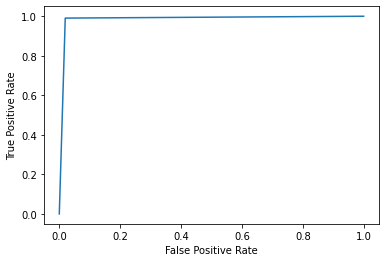

In [27]:
# plot the roc curve
fpr, tpr, _ = metrics.roc_curve(output_test,  preds)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Plot the confusion matrix 

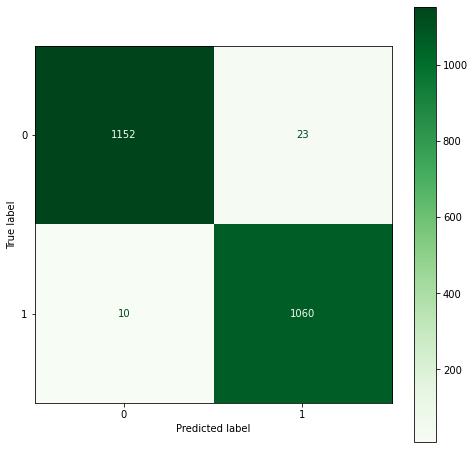

In [28]:
def plot(predictions, labels):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1, 1, 1)
  cm = metrics.confusion_matrix(labels, predictions)
  cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(2))
  cm.plot(values_format='d', cmap='Greens', ax=ax)

plot(preds, output_test)

## Look at some of the wrong predictions on the test data

In [29]:
submission = test_df.copy()
submission['prediction'] = preds
submission.drop(["title_length", "text_length"], axis=1, inplace=True) 

Let's look at some of the wrong predictions made by the learned model on the test set

Articles which were true but predicted as fake:

In [30]:
temp_df = submission[(submission["output"]==1) & (submission["prediction"]==0)]
temp_df.reset_index(drop=True, inplace=True)
temp_df

,title,text,subject,date,output,prediction
0,Trump says violence by anti-fascists proves hi...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"September 14, 2017",1,0
1,Archived State Department briefing video delib...,WASHINGTON (Reuters) - Part of a U.S. State De...,politicsNews,"June 1, 2016",1,0
2,"Bernie Sanders action toy slouches, points and...",NEW YORK (Reuters) - Orders for a Bernie Sande...,politicsNews,"February 25, 2016",1,0
3,Trump’s new EPA transition team draws from oil...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"January 24, 2017",1,0
4,Syrian migrant tells Germans: Cherish your dem...,"AACHEN, Germany (Reuters) - Social Democrat Ma...",worldnews,"September 23, 2017",1,0
5,Commentary: Manic or evasive - these veep guys...,After going through a week reminiscent of Napo...,politicsNews,"October 5, 2016",1,0
6,"Soccer: Born in Japan, playing for North Korea...","TOKYO (Reuters) - Born and raised in Japan, th...",worldnews,"December 8, 2017",1,0
7,"A dead dictator, his rusting boat and a fight ...","RIJEKA, Croatia (Reuters) - In a Croatian port...",worldnews,"September 14, 2017",1,0
8,Grace Mugabe: the office worker who wanted to ...,HARARE (Reuters) - The spectacular rise and fa...,worldnews,"November 17, 2017",1,0
9,Trump administration vastly expands global ant...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 15, 2017",1,0


Articles which were fake but predicted as true:

In [31]:
temp_df = submission[(submission["output"]==0) & (submission["prediction"]==1)]
temp_df.reset_index(drop=True, inplace=True)
temp_df

,title,text,subject,date,output,prediction
0,"In White House Conference Call About Iran, St...",The contrast between the Obama White House and...,News,"July 19, 2017",0,1
1,Donald Trump On Accusations Of Sexual Assault...,Donald Trump is backed into a corner. After he...,News,"October 14, 2016",0,1
2,MITT ROMNEY TELLS TRUMP How Republicans Win El...,"In case anyone missed it, Romney had the 2012 ...",politics,"Oct 17, 2015",0,1
3,White House Staff Hiding From Reporters,Word has gone out through the White House that...,News,"May 18, 2017",0,1
4,DEMOCRATS PUSH FOR BAN AND RESTRICTIONS ON ONL...,"Once again, the gun grabbers are doing anythin...",Government News,"May 17, 2015",0,1
5,Kentucky Republicans Propose Bill To Delay Sc...,Kentucky Republicans have decided to put the p...,News,"January 9, 2016",0,1
6,"Numbskull Republican Ignores History, Says Re...",Republican Rep. Ted Poe (R-Texas) spoke with F...,News,"January 20, 2016",0,1
7,Senate Gives Trump Jr. Ultimatum: Respond By ...,The Senate Judiciary Committee just gave forme...,News,"July 20, 2017",0,1
8,TRUMP AND CRUZ ANNOUNCE A JOINT RALLY TO PROTE...,This is great and so wonderful to see the posi...,politics,"Aug 27, 2015",0,1
9,Donald Trump Hints That He Might Decide Not T...,Donald Trump just played coy and hinted that i...,News,"July 7, 2016",0,1


That's it! 

<span style="color:blue">If you found this notebook helpful, please leave your feedback or any suggestions, and kindly upvote. Thanks!</span>